# Airbnb Price Prediction with Decision Tree & Cluster-wise Decision Trees

#### Author: Xuan Lin (xxlin@uchicago.edu)

<br>

The project aims to predict the price of Airbnb listings in New York with the open dataset provided by the company. 

The focus of this project is not so much on achieving a higher $R^2$ through feature engineering but rather through attempting and tuning a variety of models, including an innovative cluster-wise decision trees algorithm that I coded from scratch.

Since this is a regression problem, the evaluation metric is $R^2$.


### Conclusions

* A single decision tree achieves a $R^2$ of **0.5952**, while cluster-wise decision trees achives **0.74**. The latter, despite computationally expensive, is quite an effective algorithm that deserves further testing and development.


* For single decision trees, spliting branches using `information` and `gini` only make slight difference in $R^2$ in this project, although it might be worthwhile to attempt both when using a different dataset.


* The performance of cluster-wise decision trees largely depends on the predictability of the classifier. For mis-classified samples, the predictions are further off from the actual values than the mean.


In [2]:
library(plyr)
library(ggplot2)
library(rpart)

### Load Data

In [3]:
# Load Airbnb listing price dataset
path = '~/Airbnb/'
df <- read.csv(paste0(path, 'listings.csv'))
print(paste0("df Dimension: ", dim(df)))

[1] "df Dimension: 50599" "df Dimension: 106"  


In [4]:
# Load and combine features from CSV files generated beforehand
new_features <- read.csv(paste0(path, 'listings_ft.csv')) # 10 columns
amenities <- read.csv(paste0(path, 'amenities_df.csv')) # 136 columns
df <- cbind(df, amenities[,-c(1:5)], new_features) # combine dataframe
print(paste0("df Dimension: ", dim(df)))

[1] "df Dimension: 50599" "df Dimension: 247"  


In [5]:
# The amenities considered "important" based on previous analysis on amenities
imp_amenities <- c('Wifi','Heating','Essentials','Kitchen','Smokedetector','Airconditioning',
                   'Carbonmonoxidedetector','TV','Shampoo','Hairdryer','Laptopfriendlyworkspace',
                   'Iron','Washer','Dryer','Dishesandsilverware','Lockonbedroomdoor','Stove',
                   'Firstaidkit','Oven','Freestreetparking','Cookingbasics','Coffeemaker',
                   'Internet','Elevator','Family.kidfriendly','CableTV','Selfcheck.in',
                   'Extrapillowsandblankets','Privateentrance','Longtermstaysallowed',
                   'Buzzer.wirelessintercom','translationmissing.en.hosting_amenity_50',
                   'Dishwasher','Hostgreetsyou','translationmissing.en.hosting_amenity_49',
                   'Petsallowed','Lockbox','Gym','Paidparkingoffpremises','X24.hourcheck.in',
                   'Bathtub','Patioorbalcony','Gardenorbackyard','Petsliveonthisproperty')

### Data Cleaning

In [6]:
# Remove '$' from price
df$price = suppressWarnings(sapply(df$price, FUN = function(x) as.integer(sub(",", "", sub(".", "", x)))))
                                   
# Remove '%' from host_response_rate
df$host_response_rate <- sapply(df$host_response_rate, FUN = function(x) as.integer(sub('%', '', '85%')))
                                
# Calculate differences between dates as features
df$host_since_day = as.numeric(as.Date('2019-12-04', format="%Y-%m-%d")-as.Date(df$host_since, format="%Y-%m-%d"))
df$first_review_day = as.numeric(as.Date('2019-12-04', format="%Y-%m-%d")-as.Date(df$first_review, format="%Y-%m-%d"))
df$last_review_day = as.numeric(as.Date('2019-12-04', format="%Y-%m-%d")-as.Date(df$last_review, format="%Y-%m-%d"))
                                
# Remove '$' from extra people
df$extra_people = suppressWarnings(sapply(df$extra_people, FUN = function(x) as.integer(sub(",", "", sub(".", "", x)))))

In [7]:
# Eliminate outliers
# The "outliers" are identified based on the exploratory analysis
df <- df[df$number_of_reviews > 0,] # Number of Reviews > 0; 40379 samples
df <- df[df$price <= 500, ]
df <- df[df$price > 0, ]

print(paste0("df Dimension: ", dim(df)))  # 39730 rows

[1] "df Dimension: 39730" "df Dimension: 250"  


### Train-Test Split

In [8]:
# 70% and 30% train-test split based on a set of listing IDs

# Load train test ids
train.id <- read.csv(paste0(path, 'train.csv'))
train.id <- train.id$id
test.id <- read.csv(paste0(path, 'test.csv'))
test.id <- test.id$id

# create train set and test set
train.set <- df[df$id %in% train.id,]
test.set <- df[df$id %in% test.id,]

#print dimension
print(paste0("Train Set Dimension: ", paste(dim(train.set), collapse = ', ')))
print(paste0("Test Set Dimension: ", paste(dim(test.set), collapse = ', ')))

[1] "Train Set Dimension: 19787, 250"
[1] "Test Set Dimension: 8481, 250"


### Evaluation Functions: $R^2$

In [9]:
r2 <- function(pred.y, true.y){
    sst = sum((true.y - mean(true.y))^2)
    sse = sum((pred.y - true.y)^2)
    #print(sst)
    #print(sse)
    return(1-sse/sst)
    }

### Features

In [10]:
features = c('price', 'neighbourhood', 'host_since_day', 'host_location',
            'host_response_time', 'host_is_superhost','host_neighbourhood',
            'host_listings_count', "host_total_listings_count",
            'host_has_profile_pic','host_identity_verified', 'street',
            'neighbourhood_cleansed', 'neighbourhood_group_cleansed',
            'city', 'zipcode', 'property_type', 'room_type', 'accommodates',
            'bathrooms', 'bedrooms','beds', 'bed_type', 'square_feet',
            'guests_included', 'extra_people', 'number_of_reviews',
            'number_of_reviews_ltm', 'review_scores_rating', 'instant_bookable',
            'cancellation_policy', 'require_guest_profile_picture',
            'require_guest_phone_verification', 'calculated_host_listings_count',
            'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms',
            'calculated_host_listings_count_shared_rooms', 'reviews_per_month',
            'first_review_day', 'last_review_day'
            )
features <- c(features, imp_amenities)
train.subset <- train.set[,match(features, colnames(train.set))]
test.subset <- test.set[,match(features, colnames(test.set))]

In [11]:
print(paste0("Number of features: ", length(features)))

[1] "Number of features: 84"


# Single Decision Tree

* Build a full decision tree 

* cross validation

* select the best cp

#### Spliting method using Gini index

In [12]:
# Construct a tree model
gini.tree.model <- rpart(price~., data = train.subset, method = 'anova',
                   minsplit = 30, cp = 0, xval = 10, parms=list(split="gini"))
cptable <- gini.tree.model$cptable  # Save the parameter complexity table

# Aggressive Approach
gini.agg.best.cp <- cptable[which.min(cptable[,4]), 1]
gini.agg.cv.r2 <- 1-cptable[which.min(cptable[,4]), c(3,4)]
gini.agg.test.r2 <- r2(predict(prune(gini.tree.model, cp = gini.agg.best.cp), test.subset), test.subset$price)

# Conservative Approach
max.error.allowed <- sum(cptable[which.min(cptable[,4]),c(4, 5)])
acceptable.cp <- cptable[cptable[,4] < max.error.allowed,]
gini.con.best.cp <- acceptable.cp[1,1]
gini.con.cv.r2 <- 1-acceptable.cp[1,c(3,4)]
gini.con.test.r2 <- r2(predict(prune(gini.tree.model, cp = gini.con.best.cp), test.subset), test.subset$price)

#### Spliting method being information

In [13]:
# Construct a tree model
inf.tree.model <- rpart(price~., data = train.subset, method = 'anova',
                   minsplit = 30, cp = 0, xval = 10, parms=list(split="information"))
cptable <- inf.tree.model$cptable  # Save the parameter complexity table

# Aggressive Approach
inf.agg.best.cp <- cptable[which.min(cptable[,4]), 1]
inf.agg.cv.r2 <- 1-cptable[which.min(cptable[,4]), c(3,4)]
inf.agg.test.r2 <- r2(predict(prune(inf.tree.model, cp = inf.agg.best.cp), test.subset), test.subset$price)

# Conservative Approach
max.error.allowed <- sum(cptable[which.min(cptable[,4]),c(4, 5)])
acceptable.cp <- cptable[cptable[,4] < max.error.allowed,]
inf.con.best.cp <- acceptable.cp[1,1]
inf.con.cv.r2 <- 1-acceptable.cp[1,c(3,4)]
inf.con.test.r2 <- r2(predict(prune(inf.tree.model, cp = inf.con.best.cp), test.subset), test.subset$price)

#### Aggregate and compare model $R^2$s

In [14]:
eval_df <- matrix(nrow = 3,ncol = 4)
colnames(eval_df) <- c("Gini.Agg", "Gini.Con", "Inf.Agg", "Inf.Con")
rownames(eval_df) <- c("Train", "C.V.", "Test")
eval_df[,1] <- c(gini.agg.cv.r2, gini.agg.test.r2)
eval_df[,2] <- c(gini.con.cv.r2, gini.con.test.r2)
eval_df[,3] <- c(inf.agg.cv.r2, inf.agg.test.r2)
eval_df[,4] <- c(inf.con.cv.r2, inf.con.test.r2)
eval_df

,Gini.Agg,Gini.Con,Inf.Agg,Inf.Con
Train,0.6887316,0.6619677,0.6895734,0.6619677
C.V.,0.6069503,0.5997791,0.6123351,0.6048021
Test,0.5960515,0.5923208,0.5954799,0.5923208


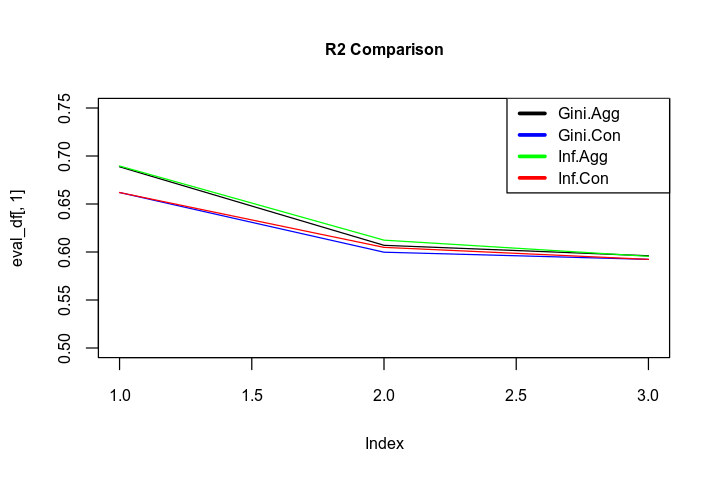

In [15]:
options(repr.plot.width = 6, repr.plot.height = 4, cex = 0.5)
plot(eval_df[,1], ylim = c(.5,.75), main = "R2 Comparison", type = 'l',
    cex.lab = .8, cex.axis = .8, cex.main = .8)
lines(eval_df[,2], col = "blue")
lines(eval_df[,3], col = "green")
lines(eval_df[,4], col = "red")
legend("topright", legend = c("Gini.Agg", "Gini.Con", "Inf.Agg", "Inf.Con"), 
       col = c("black", "blue", "green", "red"), lty = 1, lwd = 3, cex = 0.8,y.intersp=2.5, text.width = .4)

In [ ]:
Given t

In [177]:
head(prune(gini.tree.model, cp = gini.agg.best.cp)$variable.importance,20)

room_type 
                                  49837136.2 
calculated_host_listings_count_private_rooms 
                                  44175935.4 
 calculated_host_listings_count_entire_homes 
                                  43000903.1 
                                accommodates 
                                  34176305.8 
                                     zipcode 
                                  24615706.5 
                                        beds 
                                  23087205.0 
                      neighbourhood_cleansed 
                                  21925806.3 
                          host_neighbourhood 
                                  20268592.6 
                             guests_included 
                                  18854914.7 
                                    bedrooms 
                                  17163681.0 
                               neighbourhood 
                                  16377118.8 
                                      street 
                                  10238139.3 
                                        city 
                                   7579385.9 
                                   bathrooms 
                                   5843519.1 
                               host_location 
                                   4986153.7 
                neighbourhood_group_cleansed 
                                   2549124.3 
                               property_type 
                                   1849249.2 
                         host_listings_count 
                                    581797.6 
                              host_since_day 
                                    420111.3 
              calculated_host_listings_count 
                                    409280.8

In [242]:
# save tree model result
write.csv(cbind(id = test.set$id, pred.price = y.pred), 
          paste0(path, 'decisiontree_prediction.csv'), 
          row.names = FALSE)

# Cluster-Wise Decision Trees

In this project, I explored the cluster-wise decision trees algorithm based on 2 clusters. The flow chart below demonstrates how the algorithm works.

The algorithm goes through an E-M clustering process to iteratively train two decision tree regressors, in order to maximize the train set $R^2$. The the algorithm produces two outcomes--cluster labels and one regressor for each cluster. Then I trained a decision tree classifier against the resulting cluster labels and assigned the test set samples into the two classes with this classifier. Finally, the test set samples are fed into the regressors with respect to their belonging classes to produce the predicted price.

The train set $R^2$ is calculated with 10-fold cross-validations, given that the Airbnb dataset is not adequately large. In addition, since decision trees are prone to overfit, the algorithm has a built-in tree pruning function, which tunes the complexity parameter `cp` so that the cross-validation $R^2$ is maximized.

<img src="https://github.com/xuanamylin/airbnb-price-pred/blob/master/cluster-wise-decision-trees-demo.png?raw=true" width="300"/>

#### Strengths:

* Highly effective compared to a single decision and random forests
* The classification of samples offers analytical insights into the dataset

#### Weaknesses:

* Prolonged training time
* Requires parameter tuning and feature selection to achieve optimal result. The predictability of the classifier is especially important.


##### Algorithm Functions

In [9]:
library(clusdec)

This algorithm is built into a package (work in progress), which constains 3 core functions.

* `clustreg`: cluster-wise decision trees training model, which repeats the E-M process to train decision tree regressors


* `clustreg.pred`: cluster-wise decision trees prediction function that takes in regressors and predicted class labels.


* `clustreg.predict`: outputs the ideal test set class labels and the best test set R^2 possible, based on the regressor and a known response variable

##### Model Building

In [178]:
# Train Model
cr.2 <- clustreg(train.subset, k=2, tries = 2, sed = 2020, niter = 25, cp.conservative = TRUE)

[1] "1 try, 1 iteration, cluster 1, tree training"
[1] "1 try, 1 iteration, cluster 2, tree training"
[1] "1 try, 2 iteration, cluster 1, tree training"
[1] "1 try, 2 iteration, cluster 2, tree training"
[1] "1 try, 3 iteration, cluster 1, tree training"
[1] "1 try, 3 iteration, cluster 2, tree training"
[1] "1 try, 4 iteration, cluster 1, tree training"
[1] "1 try, 4 iteration, cluster 2, tree training"
[1] "1 try, 5 iteration, cluster 1, tree training"
[1] "1 try, 5 iteration, cluster 2, tree training"
[1] "1 try, 6 iteration, cluster 1, tree training"
[1] "1 try, 6 iteration, cluster 2, tree training"
[1] "1 try, 7 iteration, cluster 1, tree training"
[1] "1 try, 7 iteration, cluster 2, tree training"
[1] "1 try, 8 iteration, cluster 1, tree training"
[1] "1 try, 8 iteration, cluster 2, tree training"
[1] "1 try, 9 iteration, cluster 1, tree training"
[1] "1 try, 9 iteration, cluster 2, tree training"
[1] "1 try, 10 iteration, cluster 1, tree training"
[1] "1 try, 10 iteration, clus

In [179]:
# Train R2 (Overall)
cr.2$rsq

[1] 0.8426781

In [180]:
# Ideal Test Set R2
# This the best possible performance on the test set, given the regressors
cr.pred.2 <- clustreg.predict(cr.2, test.subset)
cr.pred.2$rsq

[1] 0.8163646

In [181]:
# Build classifier

features = c('price', 'neighbourhood', 'host_since_day', 'host_location',
            'host_response_time', 'host_is_superhost','host_neighbourhood',
            'host_listings_count', "host_total_listings_count",
            'host_has_profile_pic','host_identity_verified', 'street',
            'neighbourhood_cleansed', 'neighbourhood_group_cleansed',
            'city', 'zipcode', 'property_type', 'room_type', 'accommodates',
            'bathrooms', 'bedrooms','beds', 'bed_type', 'square_feet',
            'guests_included', 'extra_people', 'number_of_reviews',
            'number_of_reviews_ltm', 'review_scores_rating', 'instant_bookable',
            'cancellation_policy', 'require_guest_profile_picture',
            'require_guest_phone_verification', 'calculated_host_listings_count',
            'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms',
            'calculated_host_listings_count_shared_rooms', 'reviews_per_month',
            'first_review_day', 'last_review_day'
            )
class.features <- c(features, imp_amenities)
class.train.subset <- train.set[,match(class.features, colnames(train.set))]
class.test.subset <- test.set[,match(class.features, colnames(test.set))]

tree.classifier <- rpart(cluster~., data = cbind(class.train.subset, cluster = cr.2$cluster-1), 
                         method = 'class',xval = 12, cp = 0, minsplit = 0, parms=list(split="information"))
cptable <- tree.classifier$cptable

# Parameter tuning
# Method 1: Conservative
#max.error.allowed <- sum(cptable[which.min(cptable[,4]),c(4, 5)])
#acceptable.cp <- cptable[cptable[,4] < max.error.allowed,]
#best.cp <- acceptable.cp[1,1]

# Method 2: Agressive
best.cp <- cptable[which.min(cptable[,4]), 1]

tree.classifier <- rpart(cluster~., data = cbind(class.train.subset, cluster = cr.2$cluster-1), method = 'class',xval = 12,
                        cp = best.cp)

In [207]:
# Classifier Accuracy
tree.class.train <- as.integer(predict(tree.classifier, type = 'class'))
tree.class.test <- as.integer(predict(tree.classifier, newdata = class.test.subset, type = 'class'))
print(paste0("Train Class Acc: ", sum(tree.class.train == (cr.2$cluster)) / dim(train.subset)[1]))
print(paste0("Test Class Acc: ", sum(tree.class.test == cr.pred.2$cluster)/dim(test.subset)[1]))

[1] "Train Class Acc: 0.977055642593622"
[1] "Test Class Acc: 0.947765593679991"


The classifier is in fact quite predictive, with only about 5% misclassifications on the test set.

##### Test Set Price Prediction

In [184]:
# Predict for the test set
tree.class.test <- as.integer(predict(tree.classifier, newdata = test.subset, type = 'class'))
tree.pred <- clustreg.pred(cr.2, test.subset, tree.class.test)
tree.pred$rsq

[1] 0.7343788

The cluster-wise decision trees are able to achieve a **0.7343** $R^2$, which is a significant improvement from the **0.5952** $R^2$ of the single decisin tree.

##### Brief Analysis on Model Performance

Calculate the $R^2$ of the two regressors on their respective classes, for both the train and the test set. It is fair to conclude that the test performance doesn't quite match up with the train performance. This is largely due to the misclassifications.

In [211]:
# Training set accuracy by regressor
r2(cr.2.train.pred$yhat[cr.2$cluster == 1], train.subset$price[cr.2$cluster == 1])
r2(cr.2.train.pred$yhat[cr.2$cluster == 2], train.subset$price[cr.2$cluster == 2])

[1] 0.8776525

[1] 0.7530152

In [212]:
# Test set accuracy by regressor
r2(tree.pred$yhat[tree.class.test == 1], test.subset$price[tree.class.test == 1])
r2(tree.pred$yhat[tree.class.test == 2], test.subset$price[tree.class.test== 2])

[1] 0.7417148

[1] 0.6611668

Calculate the $R^2$ for correctly classified and misclassified test samples. For the 5.22% classified samples, the $R^2$ is as poor as -0.7495, meaning that the predictions are even worse than the mean. The regressors seem to perform well on the correctly classified samples--the 0.8303 test $R^2$ is on par on the train $R^2$.

In [186]:
# R2 for correctly-classified and mis-classified sets
r2(tree.pred$yhat[tree.class.test == cr.pred.2$cluster], test.subset$price[tree.class.test == cr.pred.2$cluster])
r2(tree.pred$yhat[tree.class.test != cr.pred.2$cluster], test.subset$price[tree.class.test != cr.pred.2$cluster])

[1] 0.8303463

[1] -0.7494875

In [203]:
print(paste0("Misclassification: ", sum(tree.class.test != cr.pred.2$cluster) / dim(test.subset)[1]))

[1] "Misclassification: 0.0522344063200094"


##### Feature Importance

In [258]:
# Regressor 1
cr.2$results[[1]]$variable.importance

room_type 
                                 39396546.60 
calculated_host_listings_count_private_rooms 
                                 34767302.50 
 calculated_host_listings_count_entire_homes 
                                 32724175.42 
                                accommodates 
                                 31116790.03 
                                        beds 
                                 21491432.11 
                                    bedrooms 
                                 21147781.23 
                                     zipcode 
                                 14622668.34 
                          host_neighbourhood 
                                 12812998.40 
                      neighbourhood_cleansed 
                                 12089642.45 
                               neighbourhood 
                                  8733650.49 
                                   bathrooms 
                                  6037003.61 
                                      street 
                                  4739212.30 
                neighbourhood_group_cleansed 
                                  4437697.58 
                             guests_included 
                                  3655883.73 
                               property_type 
                                  1785723.86 
                               host_location 
                                  1295862.47 
                             listings_nearby 
                                   930213.56 
                                        city 
                                   238650.59 
                              host_since_day 
                                   215675.87 
              calculated_host_listings_count 
                                    88926.14 
                         host_listings_count 
                                    53608.99 
                   host_total_listings_count 
                                    53608.99 
                            instant_bookable 
                                    46883.34 
                        review_scores_rating 
                                    24414.60

Feature importance of the cluster 2 regressor

In [251]:
# Regressor 2
cr.2$results[[2]]$variable.importance

zipcode 
                                 22654653.54 
                      neighbourhood_cleansed 
                                 17841411.76 
                                    bedrooms 
                                 15126827.78 
                          host_neighbourhood 
                                 15112671.70 
                               neighbourhood 
                                 12287773.08 
                                accommodates 
                                  9273866.73 
                                        beds 
                                  6671255.97 
                             listings_nearby 
                                  5870358.27 
                neighbourhood_group_cleansed 
                                  5458072.11 
                             guests_included 
                                  5262685.10 
                                   bathrooms 
                                  3722248.38 
                               host_location 
                                  1287016.90 
                                   room_type 
                                   776587.54 
                                      street 
                                   760290.36 
calculated_host_listings_count_private_rooms 
                                   680278.46 
 calculated_host_listings_count_entire_homes 
                                   573268.36 
                                        city 
                                   391027.58 
                               property_type 
                                    36689.18

In [213]:
# save model
#saveRDS(cr.6, paste0(path, "clustertree6-std.rds"))
# save prediction
prediction.export <- data.frame(cbind(test.set$id, tree.pred$yhat, tree.class.test, test.set$price, cr.pred.2$cluster))
colnames(prediction.export) <- c("id", "pred.price", 'pred.class', 'true.price', 'true.class')
write.csv(prediction.export, paste0(path, 'clustertree2_prediction-std-correct-73.csv'), row.names = FALSE)
head(prediction.export)

id,pred.price,pred.class,true.price,true.class
7322,84.66428,1,120,1
9782,84.66428,1,55,1
9783,51.96563,1,50,1
11174,91.51378,2,98,2
11708,91.51378,2,85,2
12192,84.66428,1,68,1


In [78]:
head(prediction.export[prediction.export$pred.class == prediction.export$true.class,])

id,pred.price,pred.class,true.price,true.class
7322,93.26558,1,120,1
9782,77.77585,1,55,1
9783,52.48320,1,50,1
11174,90.85484,2,98,2
11708,90.85484,2,85,2
12192,77.77585,1,68,1
